In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from scipy import stats

# www.u-tokyo.ac.jp

In [2]:
dfAllHops = pd.read_csv("experimentos/www.u-tokyo.ac.jp-allHops.csv", sep=",")

with open('experimentos/www.u-tokyo.ac.jp-json.json') as json_data:
    lstDic = json.load(json_data)

lstRtt = [dic['rtt'] for dic in lstDic]

In [3]:
def promedio(lst):
    return sum(lst)/len(lst)

def desvioEstandar(lst):
    prom = promedio(lst)
    return (sum([(x-prom)**2 for x in lst])/(len(lst)-1))**0.5

def calcMedia(lstRttes):
    suma = 0.0
    for rtt,_,_ in lstRttes:
        suma += rtt
    return suma/len(lstRttes)


def calcDesvioEstandar(lstRttes, media):
    suma = 0.0
    for rtt,_,_ in lstRttes:
        suma += (rtt - media)**2
    return (suma/(len(lstRttes)-1))**(0.5)


def calcValorAbsDesv(lstRttes, media):
    for i in range(len(lstRttes)):
        lstRttes[i][2] = abs(lstRttes[i][0] - media)


def calcTau(n):
    #Studnt, p<0.05, 2-tail, alpha=0.05
    t = stats.t.ppf(1-0.025, n-2)
    return (t*(n-1)) / ((n**0.5)*((n-2 + t**2)**0.5))


def anteriorNoNull(lst, idxNull):
    for i in range(idxNull-1, 0, -1):
        if lst[i]['ip_address'] != 'null':
            return i


def posteriorNoNull(lst, idxNull):
    for i in range(idxNull+1, len(lst)):
        if lst[i]['ip_address'] != 'null':
            return i


def dameRtts(lst):
    # si hay un null calcula el promedio del anterior no null y el siguiente no null
    lstIdxNull = []
    for i in range(len(lst)):
        if lst[i]['ip_address'] == 'null':
            lstIdxNull.append(i)
    rtt = []
    for i in range(len(lst)):
        if i not in lstIdxNull:
            rtt.append(lst[i]['rtt'])
        else:
            idxAnt = anteriorNoNull(lst,i)
            idxPost = posteriorNoNull(lst,i)
            rtt.append((lst[idxAnt]['rtt']+lst[idxPost]['rtt'])/2)
    return rtt, lstIdxNull


def cimbala(lst):
    # rttes, idx, absolute value of deviation
    rttcal, lstIdxNull = dameRtts(lst)
    lstRttes = [[abs(rttcal[i] - rttcal[i+1]), i, 0] for i in range(len(rttcal)-1)]
    lstRttES = [x[0] for x in lstRttes]
    outlierIdx = []
    hayOutlier = True
    while(hayOutlier):
        hayOutlier = False
        media = calcMedia(lstRttes)
        desvEst = calcDesvioEstandar(lstRttes, media)
        calcValorAbsDesv(lstRttes, media)
        tau = calcTau(len(lstRttes))
        tauS = desvEst*tau
        for i in range(len(lstRttes)):
            if lstRttes[i][2] > tauS:
                hayOutlier = True
                outlierIdx.append(lstRttes[i][1])
                lstRttes.pop(i)
                break
    return (outlierIdx, lstIdxNull, lstRttES)


outlierIdx, lstIdxNull, lstRttes = cimbala(lstDic)
print outlierIdx
print lstIdxNull
print lstRttes
print "len(lstRttes): ", len(lstRttes)

lstIdx1 = range(17)
lstIdxNull = range(16,20)
lstIdx2 = [19,20]
lstRttes1 = [lstRttes[i] for i in lstIdx1]
lstRttesNull = [lstRttes[i] for i in lstIdxNull]
lstRttes2 = [lstRttes[i] for i in lstIdx2]
print lstIdx1
print lstIdxNull
print lstIdx2

lstStr = []
for i in range(1, len(lstRttes)+1):
    lstStr.append(str(i)+'y'+str(i+1))
print lstStr

[2, 0, 20, 1, 7, 12, 8]
[17, 18, 19]
[2.343721753246772, 1.4256764285714318, 4.150820000000069, 0.008969999999822065, 0.3753699999999327, 0.036014545454586155, 0.18033545454546385, 1.3936099999999865, 0.6423900000001339, 0.35291121212122434, 0.17409878787884203, 0.08186999999981559, 0.669190000000329, 0.43944000000037775, 0.35864000000003315, 0.37043000000014104, 0.038329999999966446, 0.0, 0.0, 0.03832999999996822, 1.7305499999999867]
len(lstRttes):  21
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[16, 17, 18, 19]
[19, 20]
['1y2', '2y3', '3y4', '4y5', '5y6', '6y7', '7y8', '8y9', '9y10', '10y11', '11y12', '12y13', '13y14', '14y15', '15y16', '16y17', '17y18', '18y19', '19y20', '20y21', '21y22']


## RTT entre saltos (restar los valores promediados a cada salto)

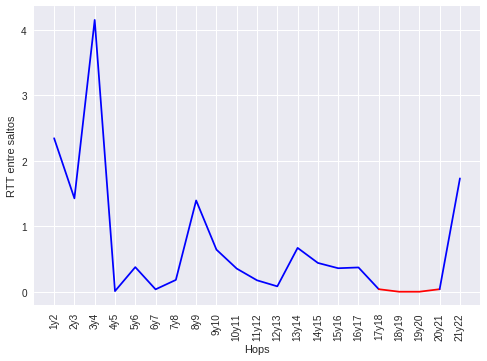

In [4]:
plt.plot(lstIdx1, lstRttes1, 'blue')
plt.plot(lstIdxNull, lstRttesNull, 'red')
plt.plot(lstIdx2, lstRttes2, 'blue')

plt.ylabel('RTT entre saltos')
plt.xlabel('Hops')
plt.xticks(range(len(lstRttes)+1), lstStr, rotation=90)
plt.show()

## RTT entre saltos en la ruta, graficar el valor (X i − X̄)/S

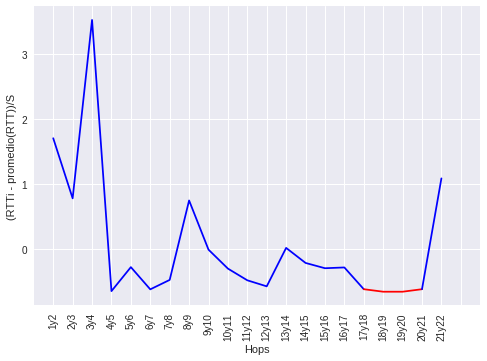

In [5]:
prom = promedio(lstRttes1 + lstRttesNull + lstRttes2)
s = desvioEstandar(lstRttes1 + lstRttesNull + lstRttes2)
lstVal1 = [(x-prom)/s for x in lstRttes1]
lstValNull = [(x-prom)/s for x in lstRttesNull]
lstVal2 = [(x-prom)/s for x in lstRttes2]

plt.plot(lstIdx1, lstVal1, 'blue')
plt.plot(lstIdxNull, lstValNull, 'red')
plt.plot(lstIdx2, lstVal2, 'blue')
plt.ylabel('(RTTi - promedio(RTT))/S')
plt.xlabel('Hops')
plt.xticks(range(len(lstRtt)+1), lstStr, rotation=90)
plt.show()

## Porcentaje que no responden los Time exceeded

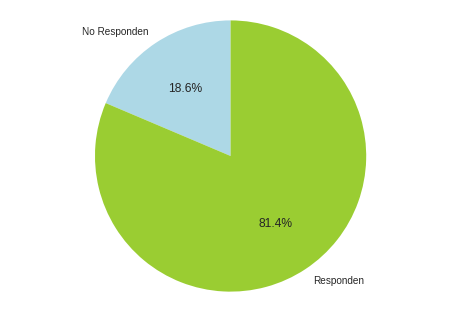

In [6]:
maxVal = max(set(dfAllHops['hop_num']))
lstTE = dfAllHops[dfAllHops['hop_num'] < maxVal]['ip_address']
cantNull = 0
for ip in lstTE:
    if ip == 'null':
        cantNull+=1

porcentajes = [cantNull, len(lstTE) - cantNull]

labels = 'No Responden', 'Responden'
explode = [0,0]

fig1, ax1 = plt.subplots()
ax1.pie(porcentajes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['lightblue', 'yellowgreen'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Cantidad de Ips por salto

In [7]:
hops = list(set(dfAllHops['hop_num']))
hops.sort()
lstSetIps = []
for h in hops:
    lstSetIps.append(set(dfAllHops[(dfAllHops['hop_num'] == h) & (dfAllHops['ip_address'] != 'null')]['ip_address']))

print lstSetIps
for s in lstSetIps:
    print len(s),

[set(['192.168.0.1']), set(['192.168.2.1']), set(['172.16.128.1']), set(['10.0.13.1']), set(['186.0.137.1']), set(['190.181.113.73']), set(['190.12.119.105']), set(['195.22.220.237']), set(['195.22.219.3']), set(['149.3.181.65']), set(['129.250.2.227']), set(['129.250.4.13']), set(['129.250.2.54']), set(['129.250.3.61']), set(['129.250.5.39']), set(['129.250.3.232']), set(['61.200.80.218']), set([]), set([]), set([]), set(['154.34.240.254']), set(['210.152.135.178'])]
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1


## Saltos internacionales

In [8]:
print [dic['salto_intercontinental'] for dic in lstDic]

[u'false', True, True, True, u'false', u'false', u'false', u'false', True, True, u'false', u'false', u'false', True, u'false', u'false', u'false', u'null', u'null', u'null', u'false', True]
